Authors: Ata & Denis

# Intro
A Program that predicts whether a stock market will go up or down. Hypothesis: using only past stock market data is insufficient to predict future of stock market due to its vulnerability to many outside factors. We will discuss whether this is true, if yes, then how can we improve it.

In [ ]:
import yfinance as yf
import pandas as pd
import os

This section downloads historical data for the S&P 500 index using the yfinance library.

In [ ]:
if os.path.exists("sp500.csv"):
    sp500 = pd.read_csv("sp500.csv", index_col=0)
else:
    sp500 = yf.Ticker("^GSPC")
    sp500 = sp500.history(period="max")
    sp500.to_csv("sp500.csv")

In [ ]:
sp500.index = pd.to_datetime(sp500.index) #it ensures the date index is correctly formatted for time-based operations.

Code below plots the closing prices of the S&P 500 over time using a line chart.
It helps visualize how the market has moved historically.

<Axes: xlabel='Date'>

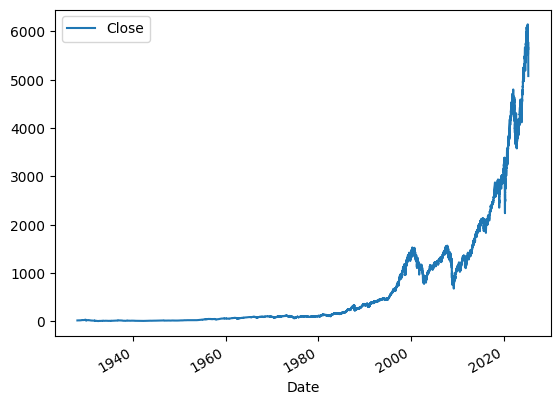

In [ ]:
sp500.plot.line(y="Close", use_index=True)

Delete unnecessary columns

In [ ]:
del sp500["Dividends"]
del sp500["Stock Splits"]

This line creates a new column called "Tomorrow" which contains the next day’s closing price.

In [ ]:
sp500["Tomorrow"] = sp500["Close"].shift(-1)

In [ ]:
sp500

,Open,High,Low,Close,Volume,Tomorrow
Date,,,,,,
1927-12-30 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,17.760000
1928-01-03 00:00:00-05:00,17.760000,17.760000,17.760000,17.760000,0,17.719999
1928-01-04 00:00:00-05:00,17.719999,17.719999,17.719999,17.719999,0,17.549999
1928-01-05 00:00:00-05:00,17.549999,17.549999,17.549999,17.549999,0,17.660000
1928-01-06 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,17.500000
...,...,...,...,...,...,...
2025-03-31 00:00:00-04:00,5527.910156,5627.560059,5488.729980,5611.850098,5257250000,5633.069824
2025-04-01 00:00:00-04:00,5597.529785,5650.569824,5558.520020,5633.069824,4434500000,5670.970215
2025-04-02 00:00:00-04:00,5580.759766,5695.310059,5571.479980,5670.970215,4243830000,5396.520020


We need to create a binary "Target" column that indicates whether the stock market went up the next day:

1 → if tomorrow’s close is higher than today’s (market went up)

0 → market stayed the same or went down

This is the label we’ll try to predict.

In [ ]:
sp500["Target"] = (sp500["Tomorrow"] > sp500["Close"]).astype(int)

In [ ]:
sp500

,Open,High,Low,Close,Volume,Tomorrow,Target
Date,,,,,,,
1927-12-30 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,17.760000,1
1928-01-03 00:00:00-05:00,17.760000,17.760000,17.760000,17.760000,0,17.719999,0
1928-01-04 00:00:00-05:00,17.719999,17.719999,17.719999,17.719999,0,17.549999,0
1928-01-05 00:00:00-05:00,17.549999,17.549999,17.549999,17.549999,0,17.660000,1
1928-01-06 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,17.500000,0
...,...,...,...,...,...,...,...
2025-03-31 00:00:00-04:00,5527.910156,5627.560059,5488.729980,5611.850098,5257250000,5633.069824,1
2025-04-01 00:00:00-04:00,5597.529785,5650.569824,5558.520020,5633.069824,4434500000,5670.970215,1
2025-04-02 00:00:00-04:00,5580.759766,5695.310059,5571.479980,5670.970215,4243830000,5396.520020,0


This line removes all rows before January 1, 1990 to focus on more recent market behavior. This helps avoid outdated patterns and focuses the model on modern trends.

In [ ]:
sp500 = sp500[pd.to_datetime(sp500.index, utc=True) >= pd.Timestamp("1990-01-01", tz="UTC")]

In [ ]:
sp500

,Open,High,Low,Close,Volume,Tomorrow,Target
Date,,,,,,,
1990-01-02 00:00:00-05:00,353.399994,359.690002,351.980011,359.690002,162070000,358.760010,0
1990-01-03 00:00:00-05:00,359.690002,360.589996,357.890015,358.760010,192330000,355.670013,0
1990-01-04 00:00:00-05:00,358.760010,358.760010,352.890015,355.670013,177000000,352.200012,0
1990-01-05 00:00:00-05:00,355.670013,355.670013,351.350006,352.200012,158530000,353.790009,1
1990-01-08 00:00:00-05:00,352.200012,354.239990,350.540009,353.790009,140110000,349.619995,0
...,...,...,...,...,...,...,...
2025-03-31 00:00:00-04:00,5527.910156,5627.560059,5488.729980,5611.850098,5257250000,5633.069824,1
2025-04-01 00:00:00-04:00,5597.529785,5650.569824,5558.520020,5633.069824,4434500000,5670.970215,1
2025-04-02 00:00:00-04:00,5580.759766,5695.310059,5571.479980,5670.970215,4243830000,5396.520020,0


# Building and Training the Model
	•	RandomForestClassifier is used — a machine learning model that makes predictions based on patterns in past data.
	•	The model is trained on all data except the last 100 rows (which are saved for testing).
	•	It uses five features: "Close", "Volume", "Open", "High", and "Low".
	•	It tries to learn whether the stock will go up (Target = 1) or down (Target = 0).

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

train = sp500.iloc[:-100]
test = sp500.iloc[-100:]

predictors = ["Close", "Volume", "Open", "High", "Low"]
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=100, random_state=1)

This section calculates the precision score of the model’s predictions. Precision is the ratio of true positive predictions to the total number of positive predictions made. It is a useful metric when dealing with imbalanced datasets.

	•	The model is used to predict the stock market direction for the last 100 days (the test set).
	•	These predictions are compared to the actual outcomes using precision score.
	•	Precision tells us how many of the predicted “ups” were actually correct.
	•	A higher precision means the model is better at identifying when the market will rise.

In [ ]:
from sklearn.metrics import precision_score

preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)

0.550561797752809

***Visualizing Predictions vs. Reality***

	•	We combine the actual market movements (Target) with the model’s predictions.
	•	Then, we plot both on the same graph to compare how closely the model’s predictions match real market outcomes.
	•	This helps us visually check if the model is doing a good job.

<Axes: xlabel='Date'>

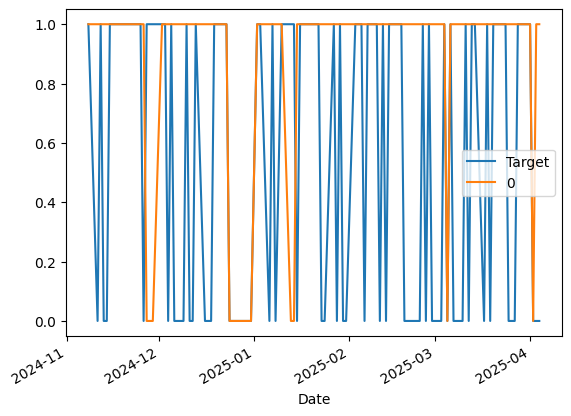

In [ ]:
combined = pd.concat([test["Target"], preds], axis=1)
combined.plot()

***Prediction and Backtesting***

predict():

	•	Trains the model on historical data (train).
	•	Uses the trained model to predict stock movement on test data.
	•	Returns a DataFrame showing actual vs predicted values.

backtest():

	•	Simulates how the model would perform over time, starting after the first 2500 days.
	•	It retrains the model every step (default 250 days).
	•	Collects predictions across different time periods to simulate real-world use.
	•	Returns a full history of predictions vs actual outcomes.

In [ ]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)

    return pd.concat(all_predictions)

  •	backtest(...) runs the model through historical data and stores its predictions.
  •	value_counts() tells us how many times the model predicted an up day (1) or down day (0).

In [ ]:
predictions = backtest(sp500, model, predictors)
predictions["Predictions"].value_counts()

,count
Predictions,
0,3736
1,2645


	•	It calculates the precision score, which is the percentage of correct “up” predictions out of all “up” predictions made.

In [ ]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5289224952741021

	•	This shows the actual percentage of days the market went up (1) or down (0).

In [ ]:
predictions["Target"].value_counts() / predictions.shape[0]

,count
Target,
1,0.535809
0,0.464191


***Adding New Predictors Based on Trends***

This code adds new features to help the model spot trends in the stock market. It looks at how the current price compares to past averages and how often the market has gone up in recent days. These features give the model more context about recent price movements, which can improve prediction accuracy.

In [ ]:
horizons = [2,5,60,250,1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = sp500.rolling(horizon).mean()

    ratio_column = f"Close_Ratio_{horizon}"
    sp500[ratio_column] = sp500["Close"] / rolling_averages["Close"]

    trend_column = f"Trend_{horizon}"
    sp500[trend_column] = sp500.shift(1).rolling(horizon).sum()["Target"]

    new_predictors+= [ratio_column, trend_column]

<ipython-input-61-8d3c1d383c5e>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp500[ratio_column] = sp500["Close"] / rolling_averages["Close"]
<ipython-input-61-8d3c1d383c5e>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp500[trend_column] = sp500.shift(1).rolling(horizon).sum()["Target"]
<ipython-input-61-8d3c1d383c5e>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

Remove any rows from the dataset that have missing values (NaNs), except for "Tomorrow" column.

In [ ]:
sp500 = sp500.dropna(subset=sp500.columns[sp500.columns != "Tomorrow"])
sp500

,Open,High,Low,Close,Volume,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,
1993-12-14 00:00:00-05:00,465.730011,466.119995,462.459991,463.059998,275050000,461.839996,0,0.997157,1.0,0.996617,1.0,1.000283,32.0,1.028047,127.0,1.176082,512.0
1993-12-15 00:00:00-05:00,463.059998,463.690002,461.839996,461.839996,331770000,463.339996,1,0.998681,0.0,0.995899,1.0,0.997329,32.0,1.025151,126.0,1.172676,512.0
1993-12-16 00:00:00-05:00,461.859985,463.980011,461.859985,463.339996,284620000,466.380005,1,1.001621,1.0,0.999495,2.0,1.000311,32.0,1.028274,127.0,1.176163,513.0
1993-12-17 00:00:00-05:00,463.339996,466.380005,463.339996,466.380005,363750000,465.850006,0,1.003270,2.0,1.004991,3.0,1.006561,32.0,1.034781,128.0,1.183537,514.0
1993-12-20 00:00:00-05:00,466.380005,466.899994,465.529999,465.850006,255900000,465.299988,0,0.999431,1.0,1.003784,2.0,1.005120,32.0,1.033359,128.0,1.181856,513.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-28 00:00:00-04:00,5679.200195,5685.890137,5572.419922,5580.939941,4513330000,5611.850098,1,0.990033,0.0,0.978060,2.0,0.946032,31.0,0.988514,140.0,1.201607,527.0
2025-03-31 00:00:00-04:00,5527.910156,5627.560059,5488.729980,5611.850098,5257250000,5633.069824,1,1.002762,1.0,0.988874,2.0,0.951997,32.0,0.993729,141.0,1.207863,527.0
2025-04-01 00:00:00-04:00,5597.529785,5650.569824,5558.520020,5633.069824,4434500000,5670.970215,1,1.001887,2.0,0.997661,2.0,0.956234,33.0,0.997185,142.0,1.212030,527.0


	•	200 decision trees (n_estimators=200) for better accuracy,
	•	A rule that each split must have at least 50 samples (min_samples_split=50) to prevent overfitting,
	•	A fixed random state (random_state=1) so results are reproducible.

In [ ]:
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

Updated predict function:

	•	Trains the model on the training data.
	•	Uses prediction probabilities instead of basic class labels.
	•	Applies a custom threshold of 0.6 to decide:
	•	If probability ≥ 0.6 → predict 1 (market goes up),
	•	Else → predict 0 (market goes down).
	•	Returns a DataFrame that includes both the actual values (Target) and the model’s predictions.

This helps focus on higher-confidence predictions instead of relying on the default 0.5 threshold.

In [ ]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >=.6] = 1
    preds[preds <.6] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [ ]:
predictions = backtest(sp500, model, new_predictors)

In [ ]:
predictions["Predictions"].value_counts()

,count
Predictions,
0.0,4513
1.0,867


In [ ]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5709342560553633